# A notebook for XLZD 0𝝂𝛽𝛽 requirements studies

### Preliminaries for running on Deucalion

In [1]:
import sys
sys.path.append("./modules")
import os
os.environ[ 'MPLCONFIGDIR' ] = '/home/alindote/.cache/matplotlib'
#print(os.environ.get('MPLCONFIGDIR'))

In [2]:
from Sensitivity_functions import Sensitivity_curve
from Sensitivity_functions import m_bb
from Sensitivity_functions import T_half

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from datetime import datetime 

from scipy.special import gammaincc
from scipy.optimize import curve_fit

In [3]:
%matplotlib inline 
plt.set_cmap('viridis')
matplotlib.rc('font', size=22) 
matplotlib.rc('legend', fontsize=18)    # legend fontsize
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
matplotlib.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rcParams['figure.figsize'] = (12., 9.)    # ... and big plots


float_formatter = "{:.2e}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

colors, linestyles = ['red', 'blue', 'green', 'purple', 'magenta', 'cyan', 'yellow', 'orange'], ['-', ':', '--', '-.', '-', ':', '--', '-.']
colors_Labs = ['lime', 'darkgreen', 'royalblue', 'darkviolet', 'crimson']
font_large = 24

<Figure size 640x480 with 0 Axes>

### Set baseline scenario

In [4]:
### XLZD baseline
# - 60 t mass
# - 3 mm SS/MS in z-only
# - 0.65% Eres
# - 25% LZ gamma BG
# - 99.95% BiPo rejection (with 0.1 mBq/kg Rn-222)
# - installation in Boulby
# - 10 yr exposure time

#                 signal_acc, beta_acc, gamma_acc, eres, gamma_frac, BiPo_eff
baseline_input = [0.853, 0.767, 0.098, 0.65,  0.25, 99.95] 
Lab, LXeMass = 'Boulby-1300', 60

exposure = 10 # yr

### Read from parameters YAML file

In [16]:
import yaml

with open("parameters_v0.5.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)

#print(data_loaded)
print(data_loaded.get('parameters').get('drift_field'))

{'value': [30, 100, 300], 'unit': 'V/cm', 'definition': 'average drift field in liquid'}


## Requirement: T > 5x10$^{27}$ yr (90% CL)

### 1. HL vs fraction of LZ $\gamma$ background

In [6]:
# Keep other parameters at their default values
[signal_acc, beta_acc, gamma_acc, eres, gamma_frac, BiPo_eff] = baseline_input

gamma_fractions_list = [1.5, 1.4, 1.3, 1.2, 1.1, 1., 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.25, 0.2, 0.1, 0.05, 0.025]
sens_vs_gammaFrac_10y = []
sens_vs_gammaFrac_15y = []
disc_vs_gammaFrac_10y = []
disc_vs_gammaFrac_15y = []

for gamma_frac in tqdm(gamma_fractions_list):
  
    gamma_args, beta_args = ['XLZD_1:1', LXeMass, gamma_frac], [Lab, BiPo_eff]
    FVmass_range = np.arange(0.1, 0.8*gamma_args[1], 0.1)
  
    exposure = 10
    sensitivity = np.max(Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, eres=eres, \
                                           gamma_args = gamma_args , beta_args = beta_args, \
                                           exposuretime = exposure, output = "long", metric = "Excl_90p")[0])
    sens_vs_gammaFrac_10y.append(sensitivity)
    [Sensitivity, Sensitivity_summed] = Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, \
                                                          eres=eres, gamma_args = gamma_args , 
                                                          beta_args = beta_args, exposuretime = exposure,  
                                                          metric = "Disc_3sigma")
    disc_vs_gammaFrac_10y.append(np.max(Sensitivity))

    
    exposure = 15
    sensitivity = np.max(Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, eres=eres, \
                                           gamma_args = gamma_args , beta_args = beta_args, \
                                           exposuretime = exposure, output = "long", metric = "Excl_90p")[0])
    sens_vs_gammaFrac_15y.append(sensitivity)
    [Sensitivity, Sensitivity_summed] = Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, \
                                                          eres=eres, gamma_args = gamma_args , 
                                                          beta_args = beta_args, exposuretime = exposure,  
                                                          metric = "Disc_3sigma")
    disc_vs_gammaFrac_15y.append(np.max(Sensitivity))

sens_vs_gammaFrac_10y = np.array(sens_vs_gammaFrac_10y)
sens_vs_gammaFrac_15y = np.array(sens_vs_gammaFrac_15y)
disc_vs_gammaFrac_10y = np.array(disc_vs_gammaFrac_10y)
disc_vs_gammaFrac_15y = np.array(disc_vs_gammaFrac_15y)

#print(gamma_fractions_list, sens_vs_gammaFrac)

100%|██████████| 18/18 [05:32<00:00, 18.48s/it]


In [7]:
# use a friendlier vertical scale
sens_vs_gammaFrac_10y /= 1e27
sens_vs_gammaFrac_15y /= 1e27
disc_vs_gammaFrac_10y /= 1e27
disc_vs_gammaFrac_15y /= 1e27

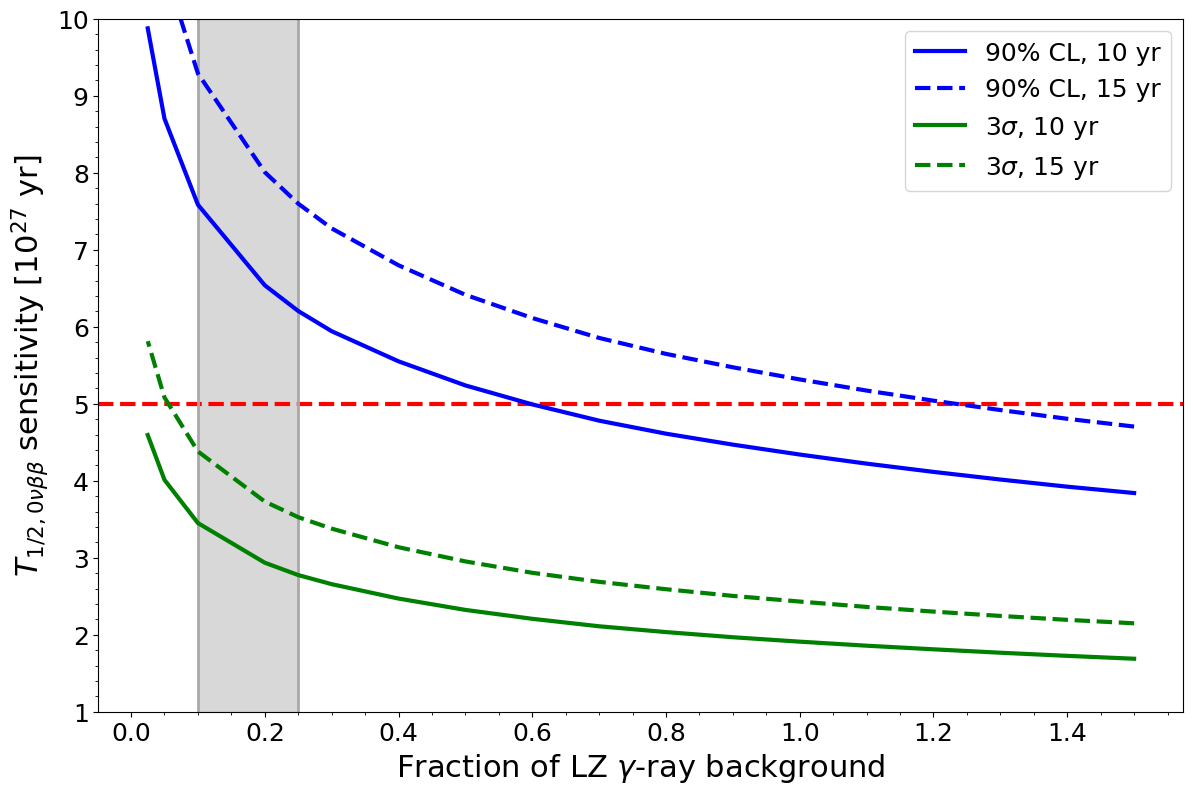

In [8]:
# Make the plot
fig, ax = plt.subplots(figsize = (14, 9))

# Requirement line
plt.axhline(5, ls = "--", lw = 3, color = "red")
#plt.text(0.01, 5e27, 'Requirement', ha = 'left', va = 'bottom', color = 'red', size = 20)
# Band showing baseline and optimistic scenarios range
plt.vlines(0.1, 1, 10, lw = 2, color = "darkgrey")
#plt.text(0.095, 1.95e28, "progressive", va = "top", ha = "right",color = "dimgrey", size = 18, rotation = 90)
plt.vlines(0.25, 1, 10, lw = 2, color = "darkgrey")  
#plt.text(0.305, 1.95e28, "baseline", va = "top", ha = "left",color = "dimgrey", size = 18, rotation = 90)
plt.fill_betweenx([1,10], [0.1, 0.1], [0.25, 0.25], color ="grey", alpha = 0.3)

plt.plot(gamma_fractions_list, sens_vs_gammaFrac_10y, color =  'b', ls = '-', lw = 3, label = '90% CL, 10 yr')
plt.plot(gamma_fractions_list, sens_vs_gammaFrac_15y, color =  'b', ls = '--', lw = 3, label = '90% CL, 15 yr')

plt.plot(gamma_fractions_list, disc_vs_gammaFrac_10y, color =  'g', ls = '-', lw = 3, label = '3$\sigma$, 10 yr')
plt.plot(gamma_fractions_list, disc_vs_gammaFrac_15y, color =  'g', ls = '--', lw = 3, label = '3$\sigma$, 15 yr')

plt.minorticks_on() 
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlabel(r'Fraction of LZ $\gamma$-ray background')
plt.ylabel(r'$ T_{1/2, 0\nu\beta\beta}$ sensitivity [10$^{27}$ yr]')
plt.ylim(1.,10.)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
#plt.yticks([1e27, 2e27, 3e27, 4e27, 5e27, 6e27, 7e27, 8e27, 9e27, 1e28],
#            [r"$1\cdot10^{27}$", r"$2\cdot10^{27}$", r"$3\cdot10^{27}$", \
#             r"$4\cdot10^{27}$", r"$5\cdot10^{27}$", r"$6\cdot10^{27}$", \
#             r"$7\cdot10^{27}$", r"$8\cdot10^{27}$", r"$9\cdot10^{27}$", r"$1\cdot10^{28}$"]);
plt.legend()